In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

# Фильтр резкости

In [3]:
def apply_sharpening_filter(image, kernel_value):
    kernel_value = kernel_value / 100.0
    sharpening_kernel = np.array([
        [0, -kernel_value, 0],
        [-kernel_value, 1 + 4 * kernel_value, -kernel_value],
        [0, -kernel_value, 0]
    ])
    sharpened_image = cv2.filter2D(image, -1, sharpening_kernel)
    return sharpened_image

# Расчет метрики

In [4]:
def calculate_sharpness_metric(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

# Прогон

In [5]:
def update_sharpening(val):
    sharpened_image = apply_sharpening_filter(image, val)
    sharpened_image = np.clip(sharpened_image, 0, 255).astype(np.uint8)
    sharpness = calculate_sharpness_metric(sharpened_image)
    text = f"Value: {val / 100:.2f}, Sharpness: {sharpness:.2f}"
    cv2.putText(sharpened_image, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    cv2.imshow("Резкость", sharpened_image)
    plot_histogram(sharpened_image, val)

# Гистограмма

In [6]:
def plot_histogram(image, kernel_value):
    plt.clf()
    plt.figure(figsize=(10, 6))
    hist, bins = np.histogram(image.ravel(), 256, [0, 256])
    smoothed_hist = gaussian_filter1d(hist, sigma=15) # Сглаживание
    peaks, _ = find_peaks(smoothed_hist, prominence=100) # Обнаружение пиков 

    colors = cm.rainbow(np.linspace(0, 1, len(peaks)))

    plt.hist(image.ravel(), 256, [0, 256], color='lightgray')

    for i, peak in enumerate(peaks):
        plt.axvline(x=bins[peak], color=colors[i], linestyle='dashed', linewidth=1, label=f'Peak {i+1}: {bins[peak]:.1f}')
        plt.bar(bins[peak], hist[peak], width=1, color=colors[i], alpha=0.5)

    plt.title(f"Гистограмма интенсивности (значение фильтра = {kernel_value / 100:.2f})")
    plt.xlabel("Интенсивность")
    plt.ylabel("Частота")
    plt.legend()
    plt.pause(0.01)
    plt.draw()
    return hist, bins

# Импорт и отображение изображения

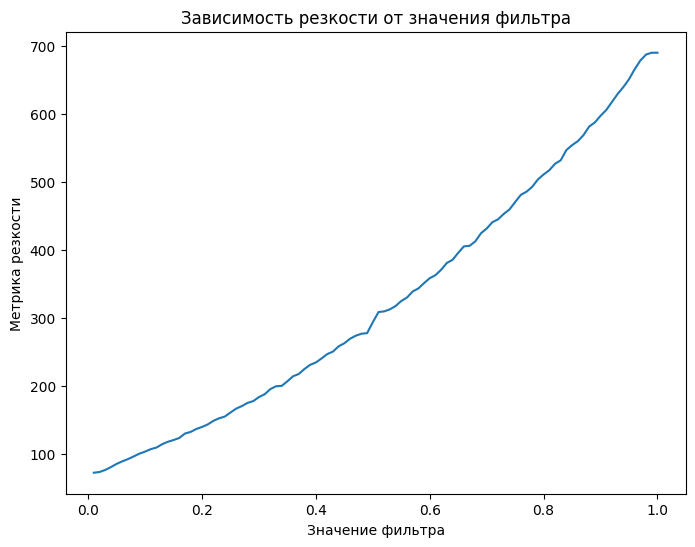

Оптимальное значение фильтра: 99.00, Максимальная метрика резкости: 690.09


<Figure size 640x480 with 0 Axes>

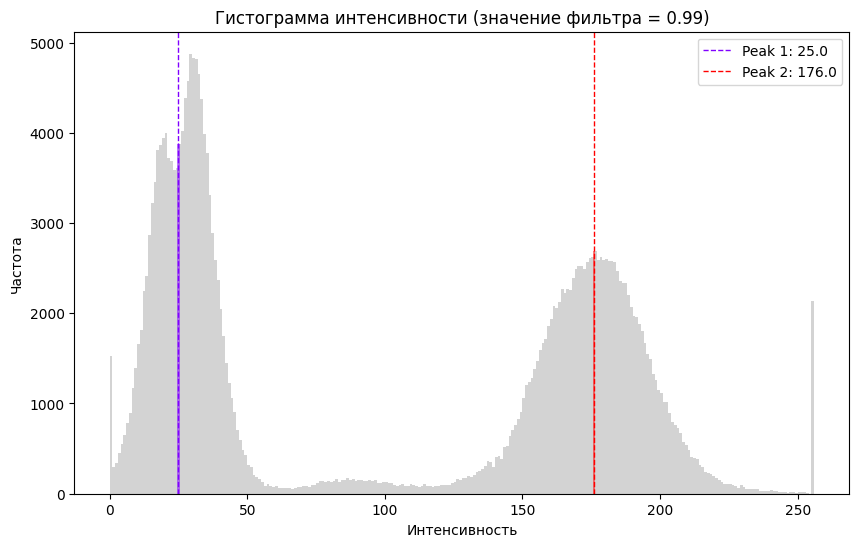

<Figure size 640x480 with 0 Axes>

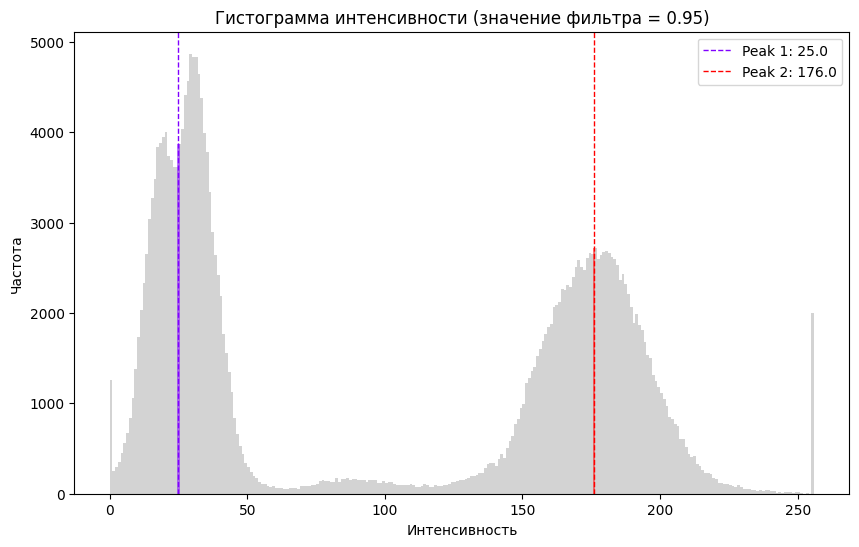

<Figure size 640x480 with 0 Axes>

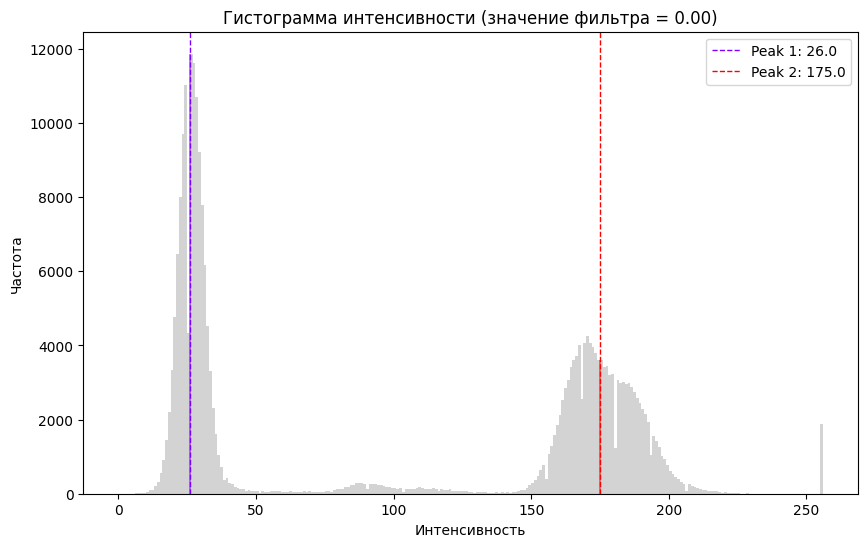

In [8]:
image_path = "00480.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print(f"Ошибка: Не удалось загрузить изображение {image_path}.")
else:
    sharpness_values = []
    kernel_values_plot = []

    for kernel_value in range(1, 101):
        sharpened_image = apply_sharpening_filter(image, kernel_value)
        sharpness = calculate_sharpness_metric(sharpened_image)
        sharpness_values.append(sharpness)
        kernel_values_plot.append(kernel_value / 100)

    max_index = np.argmax(sharpness_values)
    optimal_kernel_value = kernel_values_plot[max_index] * 100 # оптимальное значение в %

    plt.figure(figsize=(8, 6))
    plt.plot(kernel_values_plot, sharpness_values)
    plt.xlabel("Значение фильтра")
    plt.ylabel("Метрика резкости")
    plt.title("Зависимость резкости от значения фильтра")
    plt.grid(False)
    plt.show(block=False) # не блокируем


    print(f"Оптимальное значение фильтра: {optimal_kernel_value:.2f}, Максимальная метрика резкости: {sharpness_values[max_index]:.2f}")

    
    cv2.namedWindow("Резкость")
    cv2.createTrackbar("Value", "Резкость", int(optimal_kernel_value), 100, update_sharpening)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    plt.close()